In [1]:
## Imports
import glob
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPRegressor
import numpy as np
import pandas as pd
import pickle
from scipy.stats import pearsonr
import os

import skimage
import scipy
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from matplotlib import pyplot as plt


## Unsupervised Behavior Clustering
1. Once behavior features are defined in track2features.ipynb, save to features.p
2. Name your features in behavior_utils.py
3. Read your features here
4. Perform importance sampling via one round of clustering on unformly sampled data
5. Then sample across those clusters to create a new map.

This analysis is inspired by:

Sample implementation of the MotionMapper behavioral analysis methods initially described in the paper “Mapping the stereotyped behaviour of freely-moving fruit flies” by Berman, GJ, Choi, DM, Bialek, W, and Shaevitz, JW, J. Royal Society Interface, 99, 20140672 (2014).


In [2]:
## Define inputs
output_directory = "Z:/will/molies/molieSMapper/exports"
filename = "features2.p"
full_path = os.path.join(output_directory, filename)

Xs = pickle.load(open(full_path,'rb'))
sessions=list(Xs.keys())

N_feats = len(FEATURE_NAMES)

FileNotFoundError: [Errno 2] No such file or directory: 'Z:/will/molies/molieSMapper/exports/features2.p'

### Uniformly sample data for first round of t-SNE

In [ ]:
# Select your number of samples (more is better but takes longer) and
# perplexity (bigger for more samples, 5-50 is recommended)
PERPLEX_SCALE=100
N_samples=5000 #ideally 12000 (as was used in paper)
perplexity=N_samples/PERPLEX_SCALE

# uniformly sample across time for initial embedding
X = np.concatenate([Xs[s].T for s in sessions])
N_rows, N_cols = X.shape

# Check that your data dimensions fit within your parameters
assert (N_rows >= N_samples or N_cols != N_feats)

i_unif = np.linspace(0,N_rows-1,N_samples).astype(int)
X_unif = X[i_unif]

### First t-SNE embedding, visualization, and perceptron-learning of embedding function to reduce all data to 2D space

In [ ]:
X_unif_embedded = TSNE(n_components=2,perplexity=perplexity).fit_transform(X_unif)

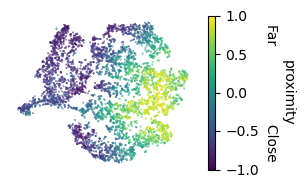

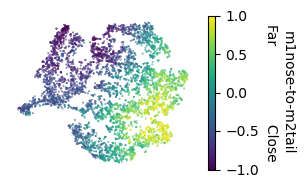

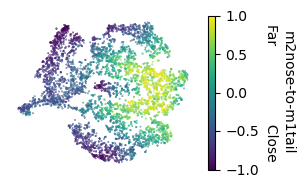

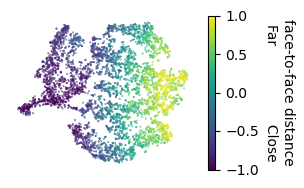

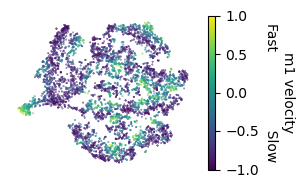

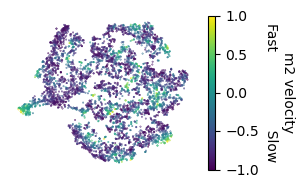

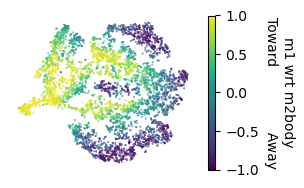

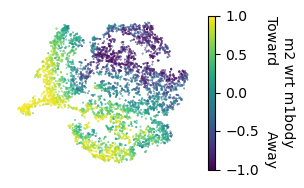

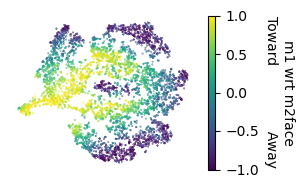

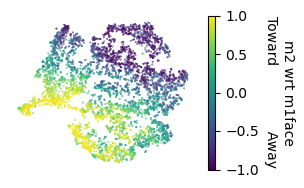

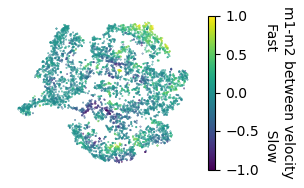

In [ ]:
# visualize variables in t-SNE space
for i in range(N_feats):
    plt.figure(figsize=(3,2))
    plt.scatter(X_unif_embedded[:,0],
                X_unif_embedded[:,1],
                c=X_unif[:,i],
                s=500/N_samples)
    plt.axis('off')
    cbar = plt.colorbar()
    cbar.set_label(FEATURE_NAMES[i]+'\n'+FEAT_RANGES[i],
                   rotation=270,va='bottom')
    plt.show()

In [ ]:
# learn the non-parametric embedding with a MLP regressor

split = int(N_samples/2) # number of samples to train vs test regressor

X_tr = X_unif[:split]
y_tr = X_unif_embedded[:split]

X_te = X_unif[split:]
y_te = X_unif_embedded[split:]


# fit regression model for mapping from N_feats to 2 t-SNE dimensions
mlp = MLPRegressor(hidden_layer_sizes=(400, 200, 50),max_iter=300)
mlp = mlp.fit(X_tr,y_tr)

In [ ]:
# predict embedding on test data
pred_te=mlp.predict(X_te)

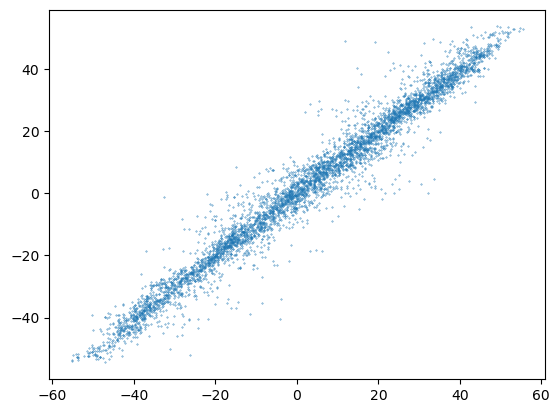

R^2=0.97


In [ ]:
# evaluate ability of MLP to match embedding

plt.figure()
plt.scatter(pred_te,y_te,s=500/N_samples)
plt.show()
var_explained = pearsonr(y_te.flatten(),pred_te.flatten())[0]**2
print(r'R^2=%.2f'%var_explained)

In [ ]:
X_embedded = mlp.predict(X)

### Create a smoothed 2 histogram and use watershed segmentation to separate "behavior clusters" MY CODE THAT SEEMS TO WORK

C:\Users\wbyrn\AppData\Local\Temp\ipykernel_40552\698913761.py:37: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


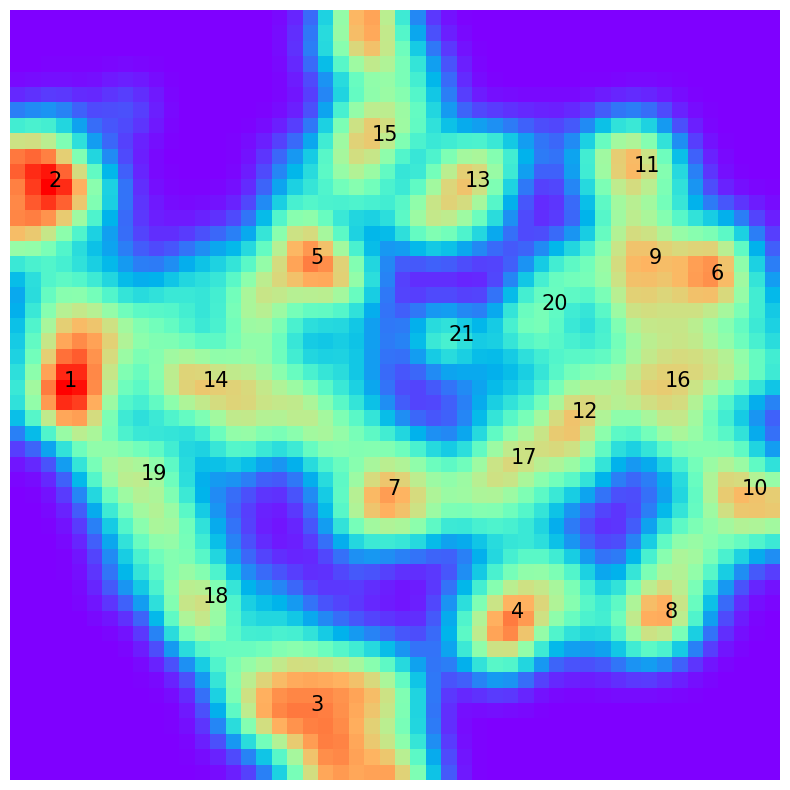

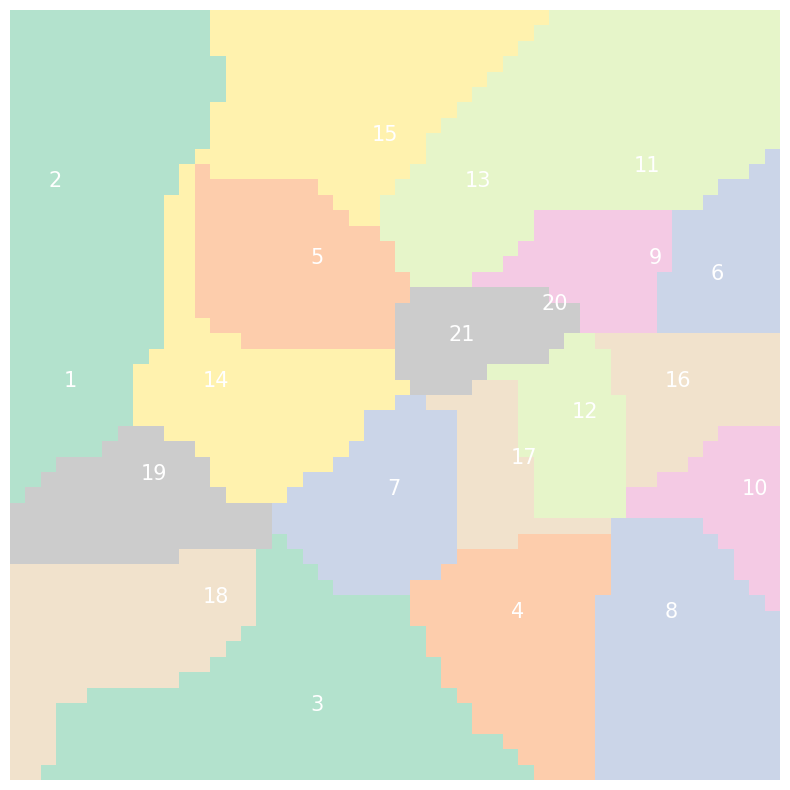

In [ ]:
from skimage.feature import peak_local_max
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

def heatmap(data, axlims=None, bins=100, density=True, sigma=0.0):
    """Generates gaussian-filtered 2D histogram of 2D data

    Args:
        data: Nx2 numerical array
        axlims: The leftmost and rightmost edges of the bins along each
                dimension (if not specified explicitly in the bins parameters):
                [[xmin, xmax], [ymin, ymax]].
                All values outside of this range will be considered outliers
                and not tallied in the histogram.
        bins:   If int, the number of bins for the two dimensions (nx=ny=bins).
                If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
                If [int, int], the number of bins in each dimension (nx, ny = bins).
                If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
                A combination [int, array] or [array, int], where int is the number of bins and
                array is the bin edges.
        normed: Default true, returns the probability density function at the bin,
                bin_count / sample_count / bin_area.
                If false, returns count per bin.
        sigma:  scalar or sequence of scalers, standard deviation(s) for Gaussian kernel.
                The standard deviations of the Gaussian filter are given for each axis as a
                sequence, or as a single number, in which case it is equal for all axes.



    Returns:
        2D array of filtered histogram,
        1D array of bin edges in dim 0,
        1D array of bin edges in dim 1

    """
    from scipy.ndimage.filters import gaussian_filter
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=bins, range=axlims, density=density)
    # Convolve with Gaussian
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap,xedges,yedges

# Parameters to change as needed
sigma = 1.5
percentile = 30
n_bins = 50

# Find local maxima as "seeds" for the watershed transform
all_map_density, xe, ye = heatmap(X_embedded, bins=n_bins, sigma=sigma) # all_map_density = matrix that contains distance between foreground and background = bigger number = more fore. biggest number = center

density_cutoff = np.percentile(all_map_density, percentile)

density_mask = all_map_density > density_cutoff # boolean matrix contain false where all_map_density is under threshhold

local_maxes = peak_local_max(all_map_density) # array of peaks in distance matrix all_map density

# Initialize markers array, markers will will be binary where 1 = local max
markers = np.zeros_like(all_map_density, dtype=int)

# Assign marker IDs at the locations of the filtered local maxima
marker_id = 1
for max_point in local_maxes:
    if density_mask[max_point[0], max_point[1]]:
        markers[max_point[0], max_point[1]] = marker_id
        marker_id += 1

# Compute watershed transform
labeled_map = watershed(-all_map_density, markers, watershed_line=False)
labeled_map = labeled_map.astype('float64')

labeled_map_viz = watershed(-all_map_density, markers, watershed_line=False)
labeled_map_viz = labeled_map_viz.astype('float64')

viz = all_map_density
viz[labeled_map_viz == 0] = 0

# Visualize all_map_density with markers
plt.figure(figsize=(10, 10))
plt.imshow(all_map_density.T, cmap='rainbow', origin='lower')

count = 1
for max_point in local_maxes:
    plt.text(max_point[0], max_point[1], str(count), color='black', fontsize=15)
    count = count + 1

plt.axis('off')
plt.show()

# Visualize labeled_map
plt.figure(figsize=(10, 10))
plt.imshow(labeled_map.T, cmap='Pastel2', origin='lower')
count = 1
for max_point in local_maxes:
    plt.text(max_point[0], max_point[1], str(count), color='white', fontsize=15)
    count = count + 1
plt.axis('off')
plt.show()



### ADAPTING ORIGINAL CODE

C:\Users\wbyrn\AppData\Local\Temp\ipykernel_40552\3393176446.py:32: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


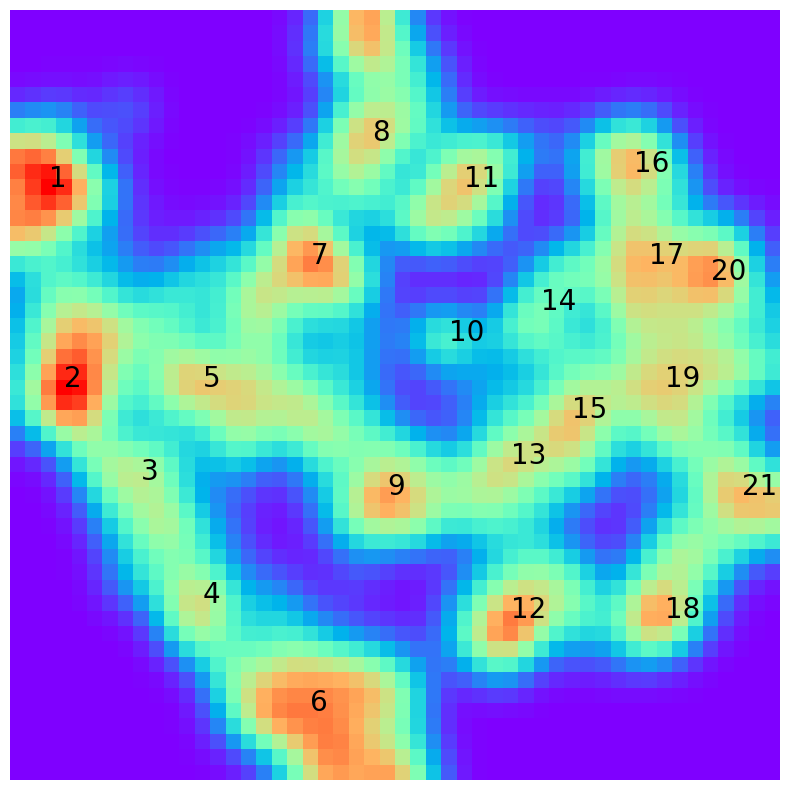

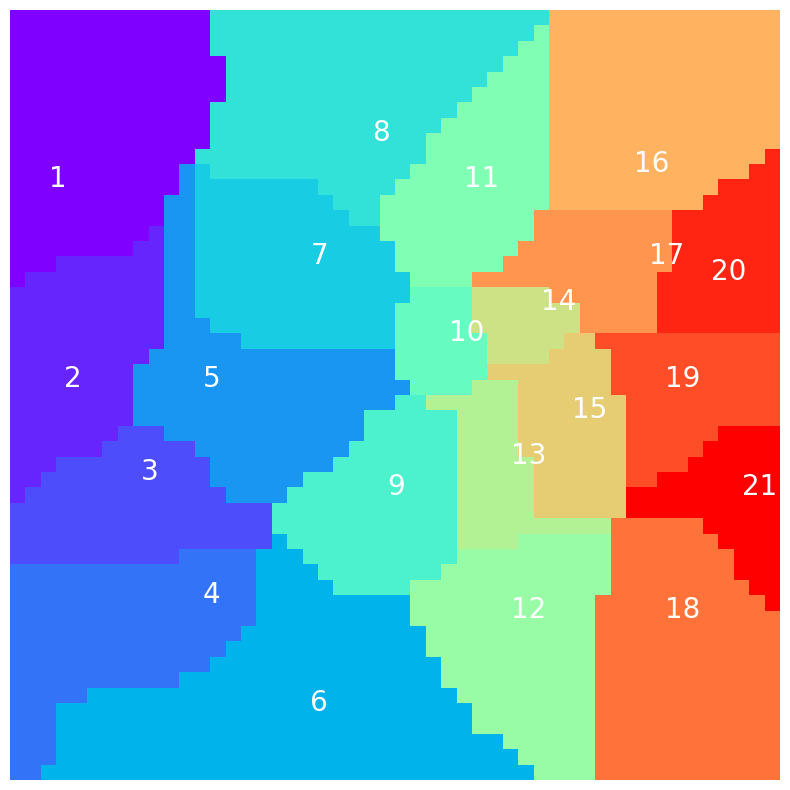

In [ ]:
def heatmap(data, axlims=None, bins=100, density=True, sigma=0.0):
    """Generates gaussian-filtered 2D histogram of 2D data

    Args:
        data: Nx2 numerical array
        axlims: The leftmost and rightmost edges of the bins along each
                dimension (if not specified explicitly in the bins parameters):
                [[xmin, xmax], [ymin, ymax]].
                All values outside of this range will be considered outliers
                and not tallied in the histogram.
        bins:   If int, the number of bins for the two dimensions (nx=ny=bins).
                If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
                If [int, int], the number of bins in each dimension (nx, ny = bins).
                If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
                A combination [int, array] or [array, int], where int is the number of bins and
                array is the bin edges.
        normed: Default true, returns the probability density function at the bin,
                bin_count / sample_count / bin_area.
                If false, returns count per bin.
        sigma:  scalar or sequence of scalers, standard deviation(s) for Gaussian kernel.
                The standard deviations of the Gaussian filter are given for each axis as a
                sequence, or as a single number, in which case it is equal for all axes.



    Returns:
        2D array of filtered histogram,
        1D array of bin edges in dim 0,
        1D array of bin edges in dim 1

    """
    from scipy.ndimage.filters import gaussian_filter
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=bins, range=axlims, density=density)
    # Convolve with Gaussian
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap,xedges,yedges

# Parameters to change as needed
sigma = 1.5
percentile = 30
n_bins = 50

# Find local maxima as "seeds" for the watershed transform
all_map_density,xe,ye = heatmap(X_embedded, bins=n_bins, sigma=sigma) # matrix with distance values

density_cutoff = np.percentile(all_map_density, percentile) # cutoff to disregard low distances 'valleys'

density_mask = all_map_density > density_cutoff # boolean mask where true when all_map_density is above density_cutoff, ie 'hills' = true

local_max_list = peak_local_max(all_map_density) # local_max_list contains coordinate pairs of peaks in the distance matrix

# OLD LINE that broke because peak_local_max changed
# local_maxes[np.logical_not(density_mask)] = False # i believe this line set true values in local maxes to false if they lived in a valley

# Initialize local_maxes array, markers will will be binary where 1 = local max
local_maxes = np.zeros_like(all_map_density, dtype=int)

# Assign 1s to local_maxes locations of the filtered local maxima
for max_point in local_max_list:
    if density_mask[max_point[0], max_point[1]]: # the coordinate at density mask is true, meaning its on a hill
        local_maxes[max_point[0], max_point[1]] = 1 # set the coordinate at local_maxes to 1, meaning its a true peak

markers, n_peaks = scipy.ndimage.label(local_maxes)

# Compute watershed transform
labeled_map = watershed(-all_map_density, markers, watershed_line=False)
labeled_map = labeled_map.astype('float64')

labeled_map_viz = watershed(-all_map_density, markers, watershed_line=False)
labeled_map_viz = labeled_map_viz.astype('float64')

viz = all_map_density
viz[labeled_map_viz==0]=0

#Visualize
plt.figure(figsize=(10,10))
plt.imshow(all_map_density.T,cmap='rainbow',origin='lower')
for i in np.unique(labeled_map.flatten()):
     x = np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
     y = np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
     plt.text(x, y, int(i), size=20)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(labeled_map.T,cmap='rainbow',origin='lower')
plt.axis('off')
for i in np.unique(labeled_map.flatten()):
     x = np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
     y = np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
     plt.text(x, y, int(i), color='white', size=20)
plt.show()

### Generate embeddings and cluster assignments across each video

In [ ]:
embeddings = {}
for k in sessions:
    test_X = Xs[k]
    embedded_mlp = mlp.predict(test_X.T)
    embeddings[k] = embedded_mlp

In [ ]:
def to_coords(xy):
    """Continuous 2D point to bin ID in 2D histogram.

    Args:
        xy: 2x1 array or tuple

    Returns:
        x bin (int)
        y bin (int)

    """

    x = (xy[0] - xmin) / (xmax - xmin) * map_shape[0]
    y = (xy[1] - ymin) / (ymax - ymin) * map_shape[1]
    if x >= map_shape[0]:
        x = map_shape[0]-1
    if y >= map_shape[1]:
        y = map_shape[1]-1
    if x < 0:
        x=0
    if y < 0:
        y=0
    return int(x), int(y)


map_shape=(n_bins,n_bins)
xmin=min(xe)
xmax=max(xe)
ymin=min(ye)
ymax=max(ye)

labels = {}

for k,e in embeddings.items():
    labels[k] = np.array([labeled_map[to_coords(point)] for point in e])

## Sample across clusters in first embedding (importance sampling)

In [ ]:
# Importance sampling
feats_sampled=[]

for k,labs in labels.items():
    for l in np.unique(labs):
        indices=np.where(labs==l)[0]
        np.random.shuffle(indices)

        # Weighted sampling acriss clusters in initial embedding
        if l==1:
            feats_sampled.append(Xs[k].T[indices[:20]])
        else:
            feats_sampled.append(Xs[k].T[indices[:10]])

X_importance_sampled =np.row_stack(feats_sampled)
X_importance_sampled.shape

(2774, 11)

## Learn second embedding from importance sampled frames

In [ ]:
X_embedded = TSNE(n_components=2,perplexity=perplexity).fit_transform(X_importance_sampled)

In [ ]:
mlp2 = MLPRegressor(hidden_layer_sizes=(400, 200, 50))
mlp2= mlp2.fit(X_importance_sampled, X_embedded)

c:\Users\wbyrn\anaconda3\envs\molegraph\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


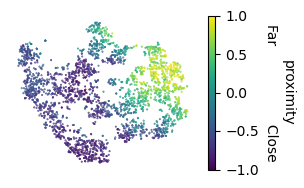

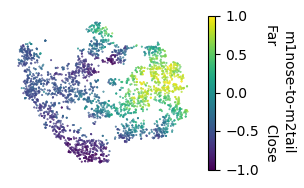

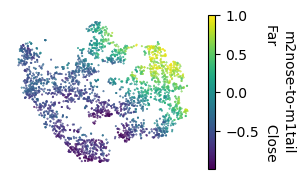

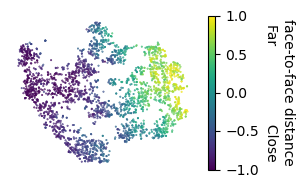

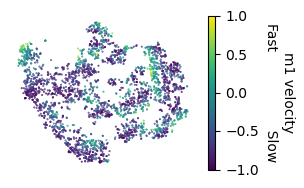

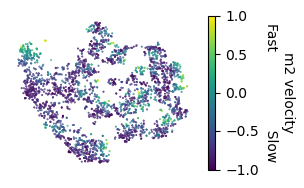

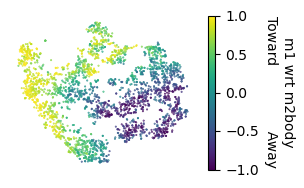

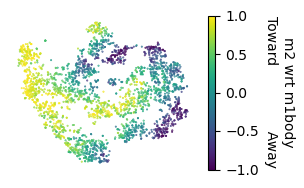

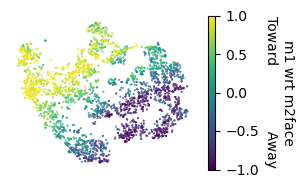

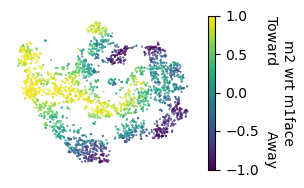

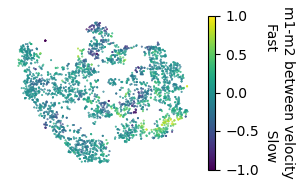

In [ ]:
# visualize variables in t-SNE space
for i in range(N_feats):
    plt.figure(figsize=(3,2))
    plt.scatter(X_embedded[:,0],
                X_embedded[:,1],
                c=X_importance_sampled[:,i],
                s=500/len(X_embedded))
    plt.axis('off')
    cbar = plt.colorbar()
    cbar.set_label(FEATURE_NAMES[i]+'\n'+FEAT_RANGES[i],
                   rotation=270,va='bottom')
    plt.show()

In [ ]:
embeddings2={}
for k in Xs.keys():
    X = Xs[k].T
    embedded_mlp = mlp2.predict(X)
    embeddings2[k]=embedded_mlp

C:\Users\wbyrn\AppData\Local\Temp\ipykernel_40552\3393176446.py:32: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


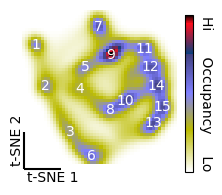

In [ ]:
X_pred = np.row_stack(tuple(embeddings2.values()))
# Find local maxima as "seeds" for the watershed tranlsform
all_map_density,xe,ye = heatmap(X_pred, bins=50, sigma=sigma)
density_cutoff = np.percentile(all_map_density, percentile)
density_mask = all_map_density > density_cutoff
local_max_list = peak_local_max(all_map_density) # local_max_list contains coordinate pairs of peaks in the distance matrix

# OLD LINE that broke because peak_local_max changed
# local_maxes[np.logical_not(density_mask)] = False # i believe this line set true values in local maxes to false if they lived in a valley

# Initialize local_maxes array, markers will will be binary where 1 = local max
local_maxes = np.zeros_like(all_map_density, dtype=int)

# Assign 1s to local_maxes locations of the filtered local maxima
for max_point in local_max_list:
    if density_mask[max_point[0], max_point[1]]: # the coordinate at density mask is true, meaning its on a hill
        local_maxes[max_point[0], max_point[1]] = 1 # set the coordinate at local_maxes to 1, meaning its a true peak

markers, n_peaks = scipy.ndimage.label(local_maxes)

# Compute watershed transform
labeled_map = watershed(-all_map_density, markers, watershed_line=False)
labeled_map = labeled_map.astype('float64')

labeled_map_viz = watershed(-all_map_density, markers, watershed_line=True)
labeled_map_viz = labeled_map_viz.astype('float64')

labeled_map2=labeled_map.copy()
for i in range(1,49):
    for j in range(1,49):
        a=labeled_map[i][j]!=labeled_map[i-1][j]
        b=labeled_map[i][j]!=labeled_map[i+1][j]
        c=labeled_map[i][j]!=labeled_map[i][j-1]
        d=labeled_map[i][j]!=labeled_map[i][j+1]
        if a or b or c or d:
            labeled_map2[i][j]=0

viz = all_map_density.copy()


plt.figure(figsize=(2.2,2.2))
im=plt.imshow(viz.T,cmap='gist_stern_r',origin='lower')
xlist=[]
ylist=[]
for i in np.unique((labeled_map).flatten()):
    x=np.where(labeled_map*local_maxes.astype(int)==i)[0][0]
    y=np.where(labeled_map*local_maxes.astype(int)==i)[1][0]
    xlist.append(x)
    ylist.append(y)
    plt.text(x,y,int(i),size=10,
            verticalalignment='center',
            horizontalalignment='center',
            color='white')
cbar=plt.colorbar(im,fraction=0.046)
cbar.set_ticks([])
cbar.set_label('Hi      Occupancy     Lo',rotation=-90,va='bottom')

plt.vlines(x=0,ymin=-2,ymax=10,color='k')
plt.text(0,-1,'t-SNE 2',rotation=90,horizontalalignment='right',verticalalignment='bottom',size=10)
plt.hlines(y=-2,xmin=0,xmax=12,color='k')
plt.text(1,-2.8,'t-SNE 1',size=10,verticalalignment='top')
plt.axis('off')
plt.show()

## New final cluster assignments

In [ ]:
map_shape=(n_bins,n_bins)
xmin=min(xe)
xmax=max(xe)
ymin=min(ye)
ymax=max(ye)

labels = {}

for k,e in embeddings2.items():
    labels[k] = np.array([labeled_map[to_coords(point)] for point in e])

## Save data maps, embeddings, and cluster labels

In [ ]:
saved = {}
saved['map'] = labeled_map
saved['projection'] = mlp2
saved['embeddings'] = embeddings2
saved['labels'] = labels

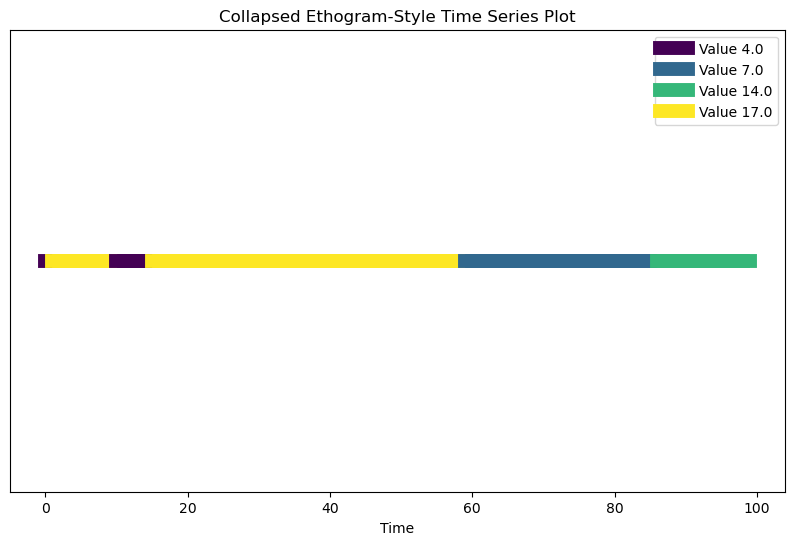

In [ ]:
# Identifying unique numbers and assigning colors

data = labels[k][0:100]
unique_numbers = np.unique(data)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_numbers)))
color_dict = dict(zip(unique_numbers, colors))

# Preparing the plot
# Adjusting the plot to have a constant y-value for all points

# Collapsing the y-limits to make the plot just about the colors

# Preparing the plot
plt.figure(figsize=(10, 6))

# Plotting colored segments for each unique number with collapsed y-limits
for i in range(len(data) - 1):
    plt.plot([i, i + 1], [0.5, 0.5], color=color_dict[data[i]], lw=10)  # Increased line width for better visibility

plt.title('Collapsed Ethogram-Style Time Series Plot')
plt.xlabel('Time')
plt.ylim(0.49, 0.51)  # Collapsing y-limits around the line
plt.yticks([])  # Remove y-axis ticks as y-value is irrelevant
plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=10, label=f'Value {num}') for num, color in color_dict.items()])
plt.show()


